In [37]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
word_vec_dim = 50
num_classes = 11

In [39]:
X_train = np.arange(num_classes).repeat(10*100*word_vec_dim).reshape(10 * num_classes, 100, word_vec_dim)
y_train = np.arange(num_classes).repeat(10)
print X_train.shape
print y_train.shape

(110, 100, 50)
(110,)


In [ ]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx] }
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [25]:
def model(X, y):
    cell = tf.contrib.rnn.LSTMCell(128)
    outputs, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32) # Outputs: N x L x W
    final_output = outputs[:, -1, :]
    y_out = tf.layers.dense(final_output, num_classes)
    
    return y_out
    
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, None, word_vec_dim])
y = tf.placeholder(tf.int64, [None])

y_out = model(X, y)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y, num_classes), logits=y_out))
optimizer = tf.train.AdamOptimizer()

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Iteration 0: with minibatch training loss = 2.19 and accuracy of 0
Iteration 1: with minibatch training loss = 2.35 and accuracy of 0
Iteration 2: with minibatch training loss = 2.79 and accuracy of 0
Iteration 3: with minibatch training loss = 2.36 and accuracy of 0
Iteration 4: with minibatch training loss = 2.17 and accuracy of 0
Iteration 5: with minibatch training loss = 2.38 and accuracy of 0
Iteration 6: with minibatch training loss = 2.22 and accuracy of 0
Iteration 7: with minibatch training loss = 2.23 and accuracy of 0
Iteration 8: with minibatch training loss = 2.11 and accuracy of 0
Iteration 9: with minibatch training loss = 2.25 and accuracy of 0
Iteration 10: with minibatch training loss = 1.72 and accuracy of 0
Epoch 1, Overall loss = 2.25 and accuracy of 0


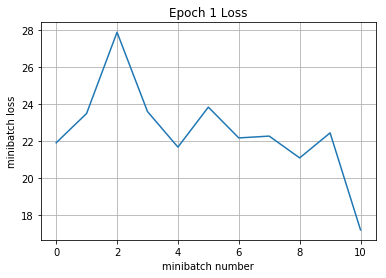

Iteration 11: with minibatch training loss = 1.97 and accuracy of 0
Iteration 12: with minibatch training loss = 1.97 and accuracy of 0
Iteration 13: with minibatch training loss = 2.07 and accuracy of 0
Iteration 14: with minibatch training loss = 1.78 and accuracy of 0
Iteration 15: with minibatch training loss = 1.98 and accuracy of 0
Iteration 16: with minibatch training loss = 2 and accuracy of 0
Iteration 17: with minibatch training loss = 1.94 and accuracy of 0
Iteration 18: with minibatch training loss = 1.79 and accuracy of 0
Iteration 19: with minibatch training loss = 1.82 and accuracy of 0
Iteration 20: with minibatch training loss = 1.98 and accuracy of 0


KeyboardInterrupt: 

In [36]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
run_model(session=sess,
          predict=y_out,
          loss_val=mean_loss,
          Xd=X_train,
          yd=y_train,
          epochs=50,
          batch_size=10,
          print_every=1,
          training=train_step,
          plot_losses=True)

Tensor("dense/BiasAdd:0", shape=(?, 11), dtype=float32)
